## _Notebook for subclass labeling, Frederick Lee, M.D._
### *2022_10_29_16_11_40__fsl*  
### ___Subclassing MLFs, Slide 2___

# 1. Setup:
* Connect drive
* Turn off cell scrolling in Jupyter notebook
* Install openslide
* Install SlideRunner

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 50000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
!apt-get install openslide-tools python3-openslide

<IPython.core.display.Javascript object>

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  javascript-common libjs-jquery libopenslide0 python-asn1crypto
  python-blinker python-cffi-backend python-click python-colorama
  python-cryptography python-enum34 python-flask python-idna python-ipaddress
  python-itsdangerous python-jinja2 python-markupsafe
  python-openslide-examples python-openssl python-pkg-resources
  python-pyinotify python-simplejson python-six python-werkzeug
  python3-olefile python3-pil
Suggested packages:
  apache2 | lighttpd | httpd libtiff-tools python-blinker-doc
  python-cryptography-doc python-cryptography-vectors python-enum34-doc
  python-flask-doc python-jinja2-doc python-openssl-doc python-openssl-dbg
  python-setuptools python-pyinotify-doc ipython python-genshi pyt

In [ ]:
!python -m pip install -U SlideRunner

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511 kB 5.0 MB/s 
     |████████████████████████████████| 2.0 MB 63.8 MB/s 
     |████████████████████████████████| 8.4 MB 65.6 MB/s 
     |████████████████████████████████| 98 kB 6.2 MB/s 
     |████████████████████████████████| 344 kB 75.7 MB/s 
     |████████████████████████████████| 59.9 MB 1.5 MB/s 


In [ ]:
# get demo slide:
# import urllib.request
# urllib.request.urlretrieve('https://ndownloader.figshare.com/files/16261553?private_link=a82ddb634864c24f4aee','9374efe6ac06388cc877.svs')

<IPython.core.display.Javascript object>

# 2. Get image patches for subclassing:  

Use the published __MEL sqlite db__ to view, choose, and subclass patches for Rajiv's Resnet ingestion, subclassifier model training, label propagation, testing, etc.:  
  
*  __Patches are dim 128 × 128 px and were:__  
    *  drawn from across ***all train slides*** 
    *  chosen as ***clear (unambiguous) examples*** of the assigned subclass,    
    *  with target of ~20 labeled patches per sublcass (× 6 subclasses = 120 patches total for initial train run)  
    *  **NB: Patches were _centered_ about the (x1, y1) coordinates provided in the sqlite db; these coordinates indicate the annotation center.**    

* __Patch subclass labels were assigned as:__  
    **1** — ***NOT used*** (reserved  as published for MLF = 'mitotic-like figure', 'hard negative', 'imposter')   
    **2** — ***NOT used*** (reserved as published for MF = 'mitotic figure')  
    **3** — ***prometaphase (PM)***  
    **4** — ***metaphase (MP)***  
    **5** — ***metaphase, rosette (MR)***   
    **6** — ***anaphase (AP), telophase (TP) (COMBINED)***  
    **7** — ***atypical mitotic figure (AMF)***   
    **8** — ***non-mitotic figure (MLF):*** same as authors' _class '1'_ above  
    **0** — ***SKIP THIS ANNOTATION (AMBIGUOUS SUBCLASS)*** 


## _a. Set gdrive paths, train/test slides & filenames:_

In [ ]:
# set path to local canine data:
path_can = 'drive/MyDrive/sam/code/dat/'

<IPython.core.display.Javascript object>

In [ ]:
# create dictionary of slide no.'s & .svs filenames as specified in PUBLISHED PAPER
# (NB: Slide no.'s in sqlite MEL db DON'T necessarily match slide no. and .svs 
# filename in published paper!)

# by manual entry:
slide_dict = {1: '4eee7b944ad5e46c60ce',
              2: 'a8773be388e12df89edd',
              3: 'deb768e5efb9d1dcbc13',
              4: 'e09512d530d933e436d5',
              5: '72c93e042d0171a61012',
              6: '2d56d1902ca533a5b509',
              7: '084383c18b9060880e82',
              8: 'da18e7b9846e9d38034c',
              9: '13528f1921d4f1f15511',
              10: 'd0423ef9a648bb66a763',
              11: '69a02453620ade0edefd',
              12: 'd37ab62158945f22deed',
              13: 'd7a8af121d7d4f3fbf01',
              14: '460906c0b1fe17ea5354',
              15: 'b1bdee8e5e3372174619',
              16: 'c4b95da36e32993289cb',
              17: '022857018aa597374b6c',
              18: '50cf88e9a33df0c0c8f9',
              19: '3d3d04eca056556b0b26',
              20: '2191a7aa287ce1d5dbc0',
              21: 'fa4959e484beec77543b'}

# create sub-dict. for train slides:
train_slide_l = [2, 3, 5, 7, 8, 10, 12, 13, 14, 16, 18, 19, 20, 21]
train_dict = {x: slide_dict[x] for x in train_slide_l}
assert len(train_dict) == 14

# create sub-dict. for test slides:
test_slide_l = [x for x in range(1,22) if x not in train_slide_l]
test_dict = {x: slide_dict[x] for x in test_slide_l}
assert len(test_dict) == 7

# verify above manually typed-in slide filenames
# via copy-pasting filenames directly from pdf of published paper:
pdf_slide_l = ['4eee7b944ad5e46c60ce',
               'a8773be388e12df89edd',
               'deb768e5efb9d1dcbc13',
               'e09512d530d933e436d5',
               '72c93e042d0171a61012',
               '2d56d1902ca533a5b509',
               '084383c18b9060880e82',
               'da18e7b9846e9d38034c',
               '13528f1921d4f1f15511',
               'd0423ef9a648bb66a763',
               '69a02453620ade0edefd',
               'd37ab62158945f22deed',
               'd7a8af121d7d4f3fbf01',
               '460906c0b1fe17ea5354',
               'b1bdee8e5e3372174619',
               'c4b95da36e32993289cb',
               '022857018aa597374b6c',
               '50cf88e9a33df0c0c8f9',
               '3d3d04eca056556b0b26',
               '2191a7aa287ce1d5dbc0',
               'fa4959e484beec77543b']

for item in slide_dict.keys():
    if slide_dict[item] == pdf_slide_l[item - 1]:
        print(f'slide {item:2d}, filename: {slide_dict[item]} is a  match!')
    else:
        assert slide_dict[item] == pdf_slide_l[item - 1]

<IPython.core.display.Javascript object>

slide  1, filename: 4eee7b944ad5e46c60ce is a  match!
slide  2, filename: a8773be388e12df89edd is a  match!
slide  3, filename: deb768e5efb9d1dcbc13 is a  match!
slide  4, filename: e09512d530d933e436d5 is a  match!
slide  5, filename: 72c93e042d0171a61012 is a  match!
slide  6, filename: 2d56d1902ca533a5b509 is a  match!
slide  7, filename: 084383c18b9060880e82 is a  match!
slide  8, filename: da18e7b9846e9d38034c is a  match!
slide  9, filename: 13528f1921d4f1f15511 is a  match!
slide 10, filename: d0423ef9a648bb66a763 is a  match!
slide 11, filename: 69a02453620ade0edefd is a  match!
slide 12, filename: d37ab62158945f22deed is a  match!
slide 13, filename: d7a8af121d7d4f3fbf01 is a  match!
slide 14, filename: 460906c0b1fe17ea5354 is a  match!
slide 15, filename: b1bdee8e5e3372174619 is a  match!
slide 16, filename: c4b95da36e32993289cb is a  match!
slide 17, filename: 022857018aa597374b6c is a  match!
slide 18, filename: 50cf88e9a33df0c0c8f9 is a  match!
slide 19, filename: 3d3d04ec

## _b. Select slide for viewing candidate patches for subclassing:_  

In [ ]:
# test input fxn in google colab:
test_input = input('Please enter any test input: ')
print(test_input)

<IPython.core.display.Javascript object>

Please enter any test input: 47
47


In [ ]:
# define fxn to get valid user input in val_range; return as val_type:
def read_val(val_type, val_range, request_msg, error_msg):
    while True:
        val = input(request_msg + ' ')
        try:
            assert val_type(val) in val_range
            return val_type(val)
        except (ValueError, AssertionError) as error:
            print(val, error, error_msg)

<IPython.core.display.Javascript object>

In [ ]:
# select slide no to view:
request_msg = f'Enter train slide no. to select:'
error_msg = f'Invalid slide no. (e.g., not a train slide); try again...\n'

slide_no = read_val(int, train_slide_l, request_msg, error_msg)
print(f'\nOK, selecting train slide {slide_no:2d}, '
      f'.svs filename: {train_dict[slide_no]}....')

<IPython.core.display.Javascript object>

Enter train slide no. to select: 2

OK, selecting train slide  2, .svs filename: a8773be388e12df89edd....


## _c. Load ***MEL*** sqlite db, chosen training slide, and published annotations:_

In [ ]:
# load published MEL sqlite db:
from SlideRunner.dataAccess.database import Database
DB = Database().open(path_can + 'annot/MITOS_WSI_CMC_MEL.sqlite')

# set slide image filename:
slide_svs = train_dict[slide_no]

slideid = DB.findSlideWithFilename(path_can + 'WSI/train/' + slide_svs + '.svs','')
DB.loadIntoMemory(slideid)

# list all the train slide annotations:
print(f'The published annots. for slide {slide_no:2d} {slide_svs + ".svs"} are:\n\n')

# (while listing annots., check if all are class spotAnnotations):
spot_annots = True

for annot in DB.annotations.keys():
    print(f'annot. {annot:5d}: {DB.annotations[annot]}, {type(DB.annotations[annot])}')

<IPython.core.display.Javascript object>

The published annots. for slide  2 a8773be388e12df89edd.svs are:


annot.     1: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03d293eb50>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     2: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03df0aad50>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     3: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03d293e9d0>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     4: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03d293ec10>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     5: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03d293ec50>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     6: <SlideRunner.dataAccess.annotations.spotAnnotation object at 0x7f03d293ec90>, <class 'SlideRunner.dataAccess.annotations.spotAnnotation'>
annot.     7: <SlideR

## _d. Verify counts of slide annotations retrieved from ***MEL sqlite db*** with published numbers:_

In [ ]:
# store PUBLISHED counts for MEL annotations in a dictionary with
# keys = slide no. in PUBLISHED paper
# values = tuple (no. MF's in MEL, no. MLF's in MEL):

slide_counts = {1: [47, 114],
                2: [64, 204],
                3: [92, 287],
                4: [87, 602],
                5: [130, 375],
                6: [139, 228],
                7: [157, 404],
                8: [187, 991],
                9: [283, 963],
                10: [378, 1143],
                11: [634, 1407],
                12: [578, 1105],
                13: [716, 1832],
                14: [673, 1199],
                15: [812, 1260],
                16: [1097, 2454],
                17: [1290, 2463],
                18: [1197, 1632],
                19: [1383, 2110],
                20: [1449, 2155],
                21: [1949, 3598]}

<IPython.core.display.Javascript object>

In [ ]:
# verify total number of annotations
assert len(DB.annotations) == sum(slide_counts[slide_no])

print(f'Σ no. annots. for slide no. {slide_no:2d} '
      f'verified as {len(DB.annotations):4d}')

# verify total annots. with agreedClass = '1' (MLF, mitotic-like figure)
# or with agreedClass = '2' (MF, mitotic figure):
annot_cl1_l = [] # list of agreedClass '1' annot. keys
annot_cl2_l = [] # list of agreedClass '2' annot. keys

for key in DB.annotations.keys():
    if DB.annotations[key].agreedClass == 1:
        annot_cl1_l.append(DB.annotations[key])
    else:
        assert DB.annotations[key].agreedClass == 2
        annot_cl2_l.append(DB.annotations[key])

assert len(annot_cl1_l) == slide_counts[slide_no][1] # verify no. MLFs
print(f'Σ no. CLASS1 (MLF) annots. for slide no. {slide_no:2d} '
      f'verified as {len(annot_cl1_l):4d}')

assert len(annot_cl2_l) == slide_counts[slide_no][0] #verify no. MFs
print(f'Σ no. CLASS2 (MF)  annots. for slide no. {slide_no:2d} '
      f'verified as {len(annot_cl2_l):4d}')

<IPython.core.display.Javascript object>

Σ no. annots. for slide no.  2 verified as  268
Σ no. CLASS1 (MLF) annots. for slide no.  2 verified as  204
Σ no. CLASS2 (MF)  annots. for slide no.  2 verified as   64


## _e. Check attributes available for an example annot. in `DB.annotations` dict. and choose relevant attributes:_  
Before listing, _remove:_  
*  dunders & sunders  
*  callables  

_see v3 of this subclassing Jn for detailed exploration of DB.annotations objects & attributes_

In [ ]:
# selected, available attributes of annots. in DB.annotations dict.:
DBannot_attr = [a for a in dir(DB.annotations[1]) \
                if not (a.startswith('__') or a.startswith('_')) \
                and (not callable(getattr(DB.annotations[1], a)))]

# example object instance attributes left after above filtering:
print(*DBannot_attr, sep='\n')

<IPython.core.display.Javascript object>

agreedClass
annotationType
clickable
coordinates
deleted
guid
labels
lastModified
minimumAnnotationLabelZoom
pluginAnnotationLabel
r
text
uid
x1
y1
zLevel


In [ ]:
# remove following uninformative attributes:
#    'annotationType'
#    'clickable'
#    'deleted'
#    'labels'
#    'lastModified'
#    'minimumAnnotationLabelZoom
#    'pluginAnnotationLabel'
#    'r'
#    'text'
#    'zlevel'

DBannot_attr = [x for x in DBannot_attr if x not in ['annotationType', \
                     'clickable', 'deleted', 'labels', 'lastModified', \
                     'minimumAnnotationLabelZoom', 'pluginAnnotationLabel', 
                     'r', 'text', 'zLevel']]

print(*DBannot_attr, sep='\n')

<IPython.core.display.Javascript object>

agreedClass
coordinates
guid
uid
x1
y1


## _f. Store selected attributes for all slide annots. in pandas df:_

In [ ]:
# initialize lists for selected attributes of slide annots. to build
# annot. df:
key_l = []    # DB.annotations dict. key
uid_l = []    # annot. uid attr.
ctr_l = []    # annot. center coord. (from annot. x1, y1 attr.)
coord_l = []  # annot. coords. attr. (gives left upper & right lower corner
              #     coord. of 50 × 50 px annot. box surrounding center coord.)
lbl_l = []    # annot. agreedClass attr.
guid_l = []   # annot. guid attr.

# create a view object of slide annotations dict.
d_items = DB.annotations.items()

# store selected attribs. for ea. slide annot. in above attr. lists:
for item in d_items:
    key_l.append(item[0])
    uid_l.append(item[1].uid)
    ctr_l.append([item[1].x1, item[1].y1])
    coord_l.append(item[1].coordinates)
    lbl_l.append(item[1].agreedClass)
    guid_l.append(item[1].guid)

<IPython.core.display.Javascript object>

### _i. dataframe of all annots. for slide in original sqlite order_

In [ ]:
# store selected attribs for slide annots in df:
import pandas as pd

annot_df = pd.DataFrame(list(zip(
    key_l, uid_l, ctr_l, coord_l, lbl_l, guid_l)), columns =
    ['key', 'uid', 'ctr', 'coord', 'lbl', 'guid'])

# view df:
#     set pd display options:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 7)

annot_df

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid
0,1,1,"[21029, 7246]","[[21004, 7221], [21054, 7271]]",1,05535b17-a3f3-48f9-ae21-dbf9617efcf1
1,2,2,"[21030, 7305]","[[21005, 7280], [21055, 7330]]",1,b1c70dda-71fc-4444-ace1-d2dbf7ce9149
2,3,3,"[20378, 6976]","[[20353, 6951], [20403, 7001]]",1,846da71e-d894-4018-9c23-a0472781a699
3,4,4,"[21086, 6940]","[[21061, 6915], [21111, 6965]]",1,eea842e0-5739-4143-995f-13053cfb8dfa
4,5,5,"[23504, 7623]","[[23479, 7598], [23529, 7648]]",1,1c886987-f274-440d-bf8b-9369ef9f6847
5,6,6,"[15300, 8437]","[[15275, 8412], [15325, 8462]]",1,c6ffc256-a24d-4f1c-b951-db79e0928719
6,7,7,"[24069, 8282]","[[24044, 8257], [24094, 8307]]",1,86c3e10c-4adf-4765-9c34-86ce3ede8d0c
7,8,8,"[14561, 9753]","[[14536, 9728], [14586, 9778]]",1,93897268-c222-4f52-9897-14f9f2708da7
8,9,9,"[14607, 9443]","[[14582, 9418], [14632, 9468]]",1,4c711ecb-3aaf-49c6-849f-4e81eb4d79e3
9,10,10,"[15481, 9406]","[[15456, 9381], [15506, 9431]]",1,bf764c0d-ebc1-4eaa-b763-0ab2e2e4d163


In [ ]:
# save annot_df to csv:
#     (add date-time stamp to filename)
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

annot_df.to_csv('drive/MyDrive/sam/subclassing (see dropbox for dbs and xlsxs)/' +
                timestr + '_annot_df_slide_no_' + str(slide_no) + '.csv')

<IPython.core.display.Javascript object>

## _ii. Sorted annotation dataframe for viewing/subclassing patches:_

### _Sort dataframe in __ascending__ order to subclass label '1's = MLFs_

In [ ]:
# sort annot_df by lbl:
annot_df_sorted = annot_df.sort_values(by='lbl', axis=0, ascending=True)

annot_df_sorted

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid
0,1,1,"[21029, 7246]","[[21004, 7221], [21054, 7271]]",1,05535b17-a3f3-48f9-ae21-dbf9617efcf1
172,1378,1378,"[12420, 28597]","[[12395, 28572], [12445, 28622]]",1,39f4c617-c398-421b-a392-ba96a3e5c493
174,1380,1380,"[28407, 29819]","[[28382, 29794], [28432, 29844]]",1,64827d9b-9de4-4672-a413-a0c58fee8bff
175,1381,1381,"[28124, 29658]","[[28099, 29633], [28149, 29683]]",1,ebd10fc9-384f-450b-ab58-aed2869658c2
176,1382,1382,"[27694, 29623]","[[27669, 29598], [27719, 29648]]",1,3b021804-0fe4-4b34-81ea-ee8be751cc8d
178,1386,1386,"[31107, 31305]","[[31082, 31280], [31132, 31330]]",1,3f2beb85-8648-4821-a308-1be404f0ed29
180,1388,1388,"[7874, 32202]","[[7849, 32177], [7899, 32227]]",1,e7002dc1-c468-424f-a5c0-f14907519e1c
181,1389,1389,"[7803, 32209]","[[7778, 32184], [7828, 32234]]",1,7e3188fe-4d34-41e5-885b-ee67f1829c2e
182,1390,1390,"[14168, 33048]","[[14143, 33023], [14193, 33073]]",1,78b554d8-9df1-4ec5-aa64-5a5ab4e022c2
183,1391,1391,"[28267, 32810]","[[28242, 32785], [28292, 32835]]",1,56ef32ec-efe9-4180-a73a-ce121240eb51


## _g. Load slide .svs image and loop through 128 × 128 px patches using above `annot_df_sorted`to subclass ~32 MLFs_  
### _NB: the only valid subclass labels in this notebook will be '8' (MLF) or '0' (ambiguous/ignore/not a clear-cut example of MLF)_


In [ ]:
# load slide .svs image:
import openslide

print(f'Loading slide no. {slide_no:2d} image file: {train_dict[slide_no] + ".svs...."}')
slide = openslide.open_slide(path_can + 'WSI/train/' + 
    train_dict[slide_no] + '.svs')

<IPython.core.display.Javascript object>

Loading slide no.  2 image file: a8773be388e12df89edd.svs....


<IPython.core.display.Javascript object>

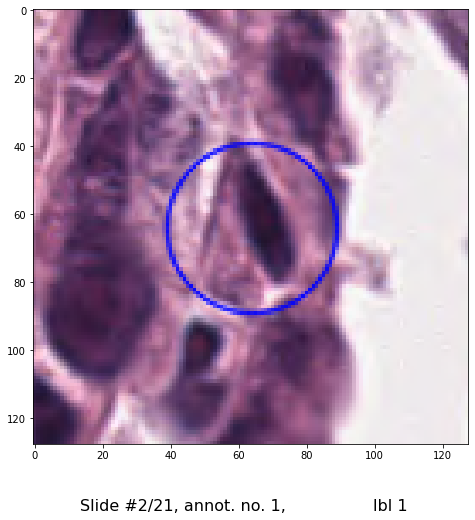

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



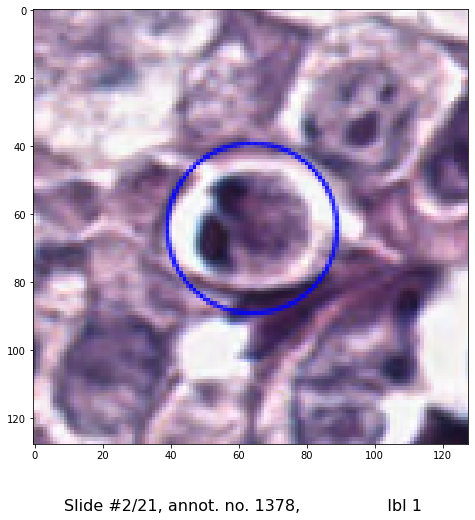

MLF subclassing label?  0


OK, confirming user subclass label =    0 written to annotation dataframe....



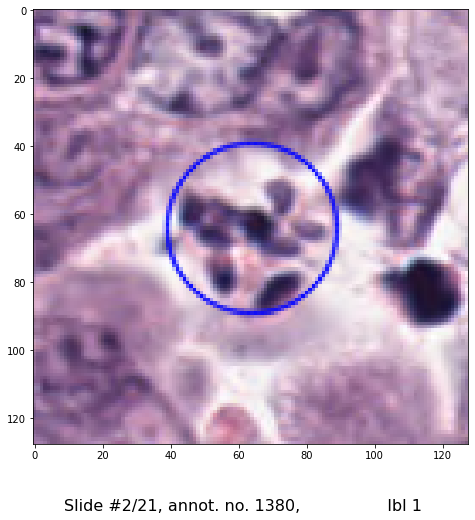

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



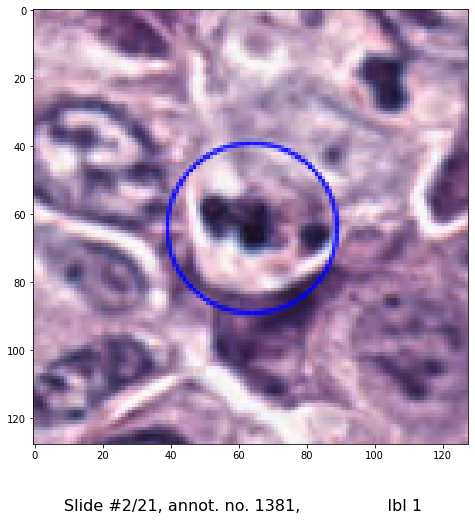

MLF subclassing label?  0


OK, confirming user subclass label =    0 written to annotation dataframe....



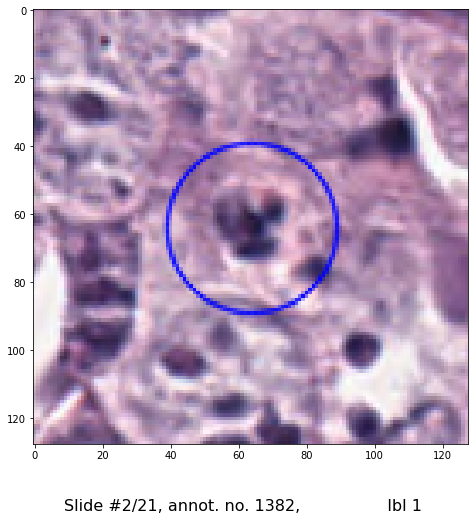

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



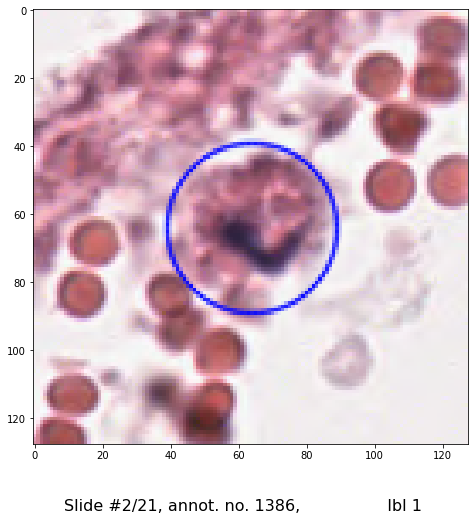

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



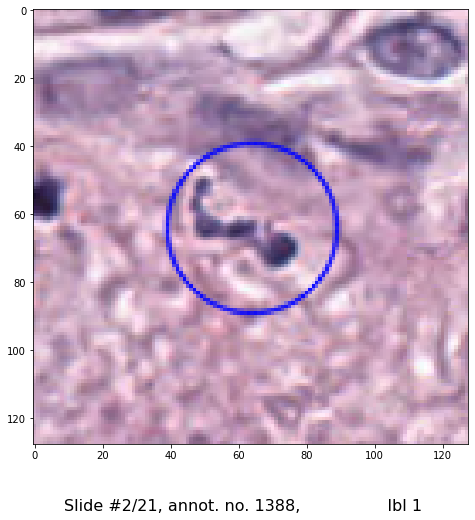

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



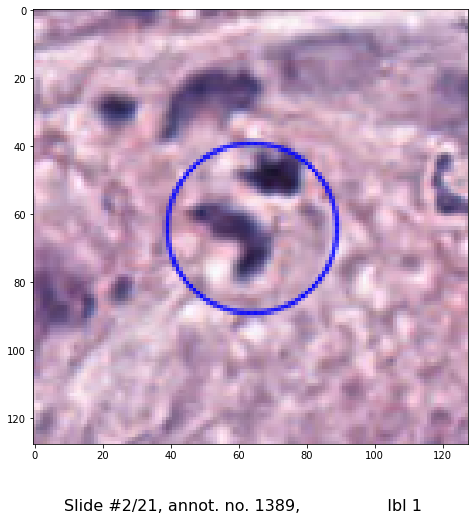

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



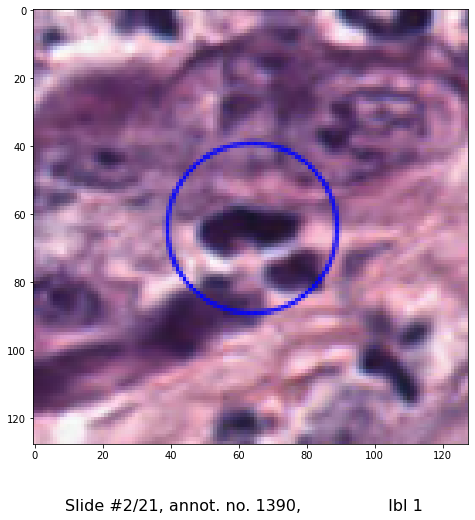

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



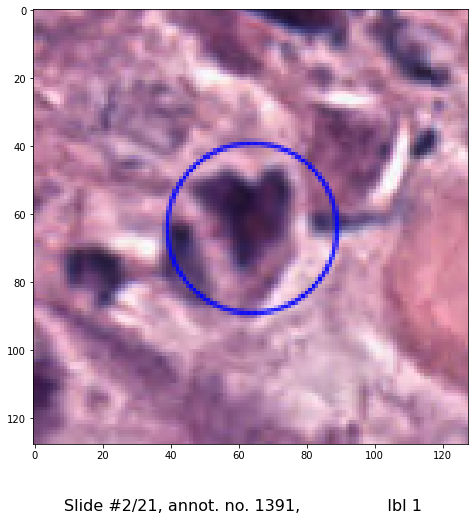

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



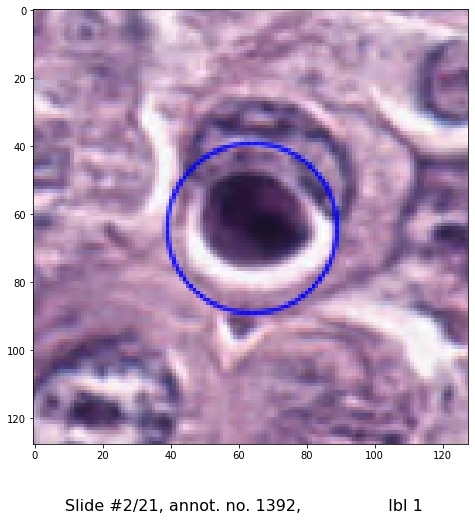

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



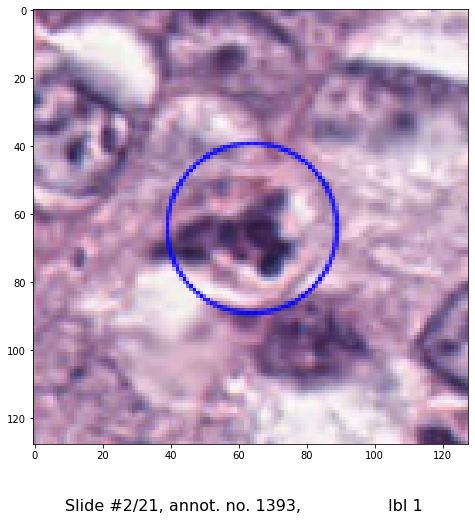

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



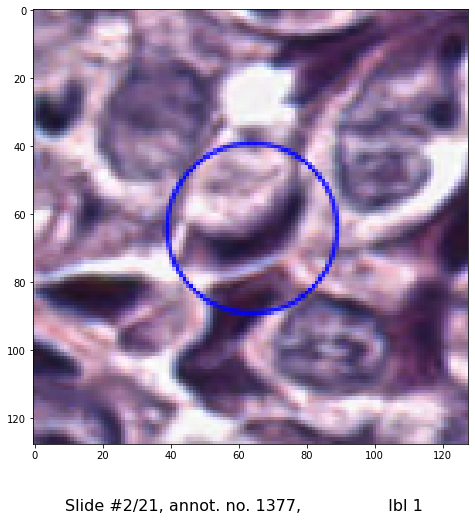

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



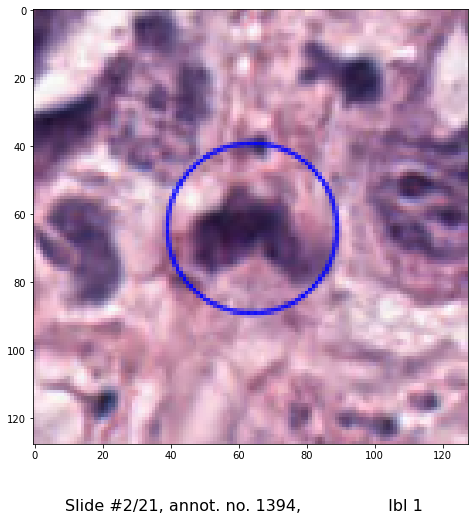

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



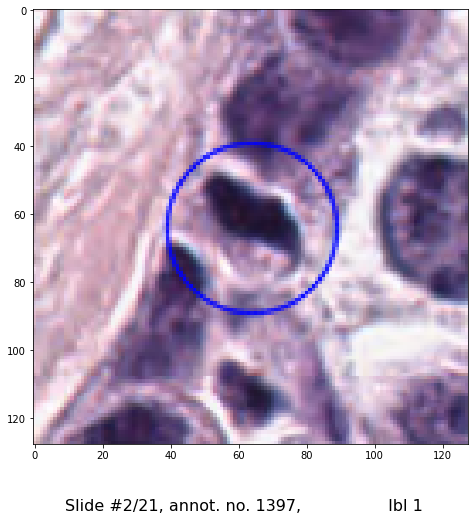

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



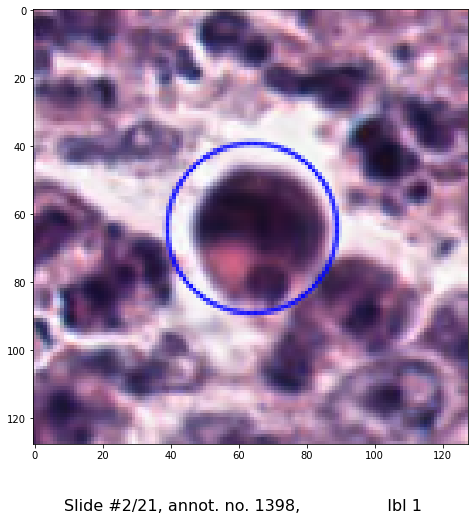

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



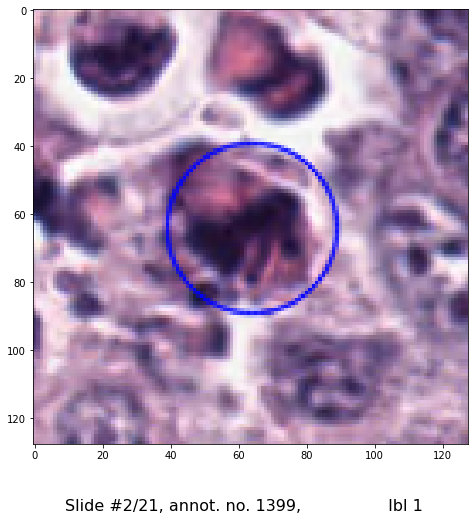

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



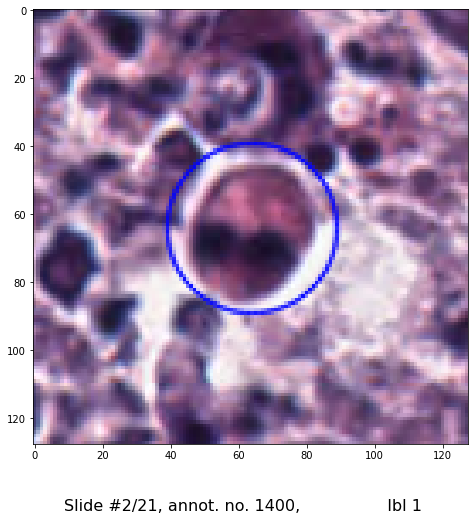

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



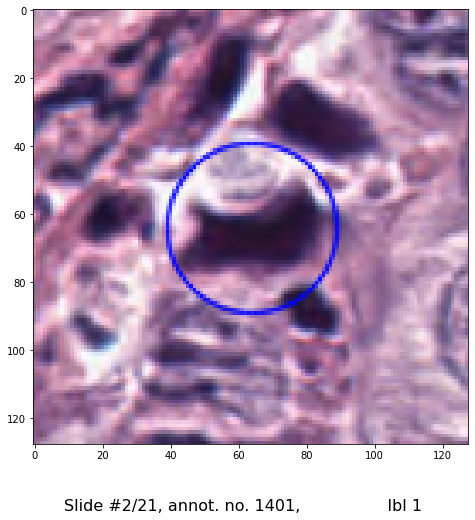

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



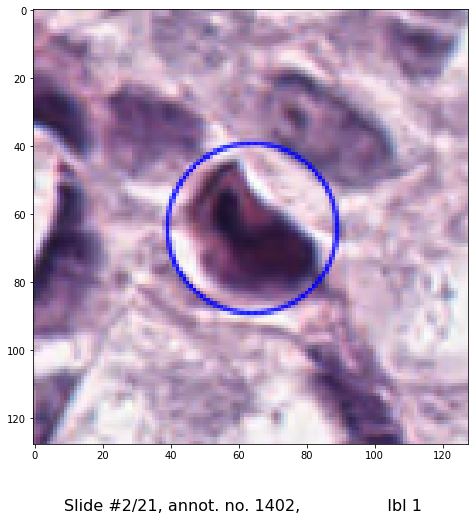

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



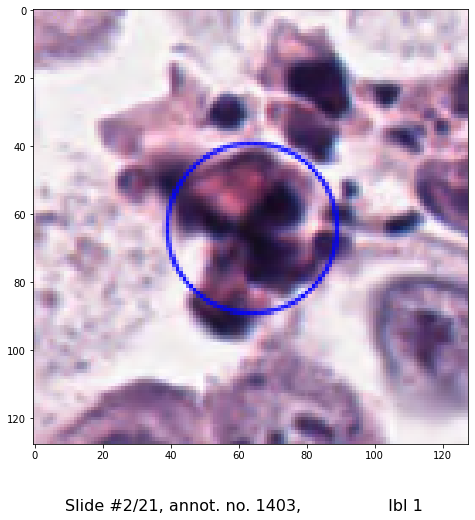

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



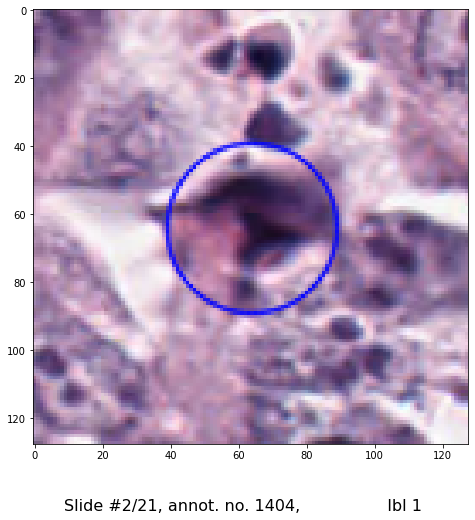

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



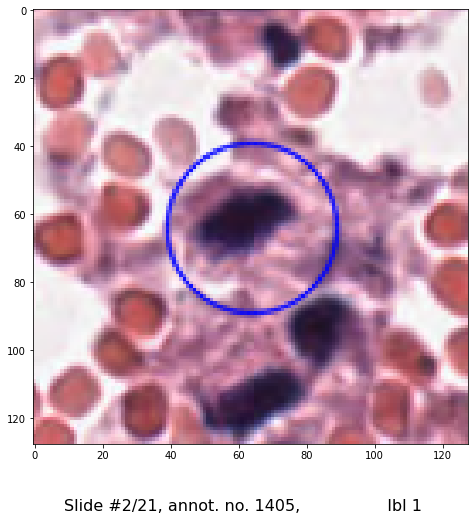

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



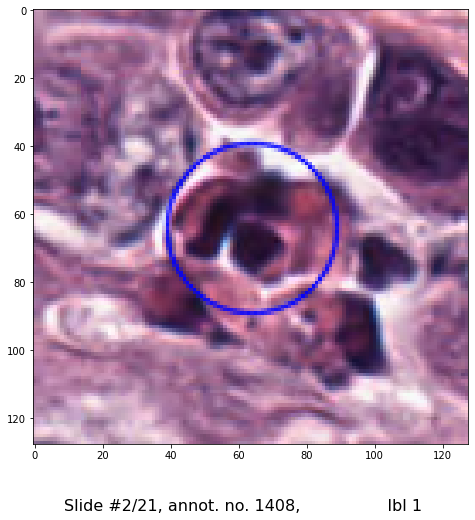

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



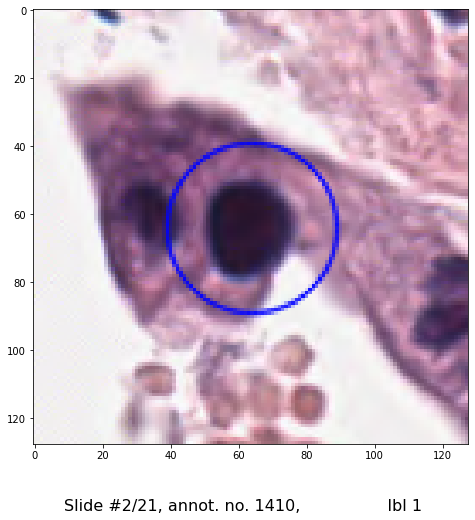

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



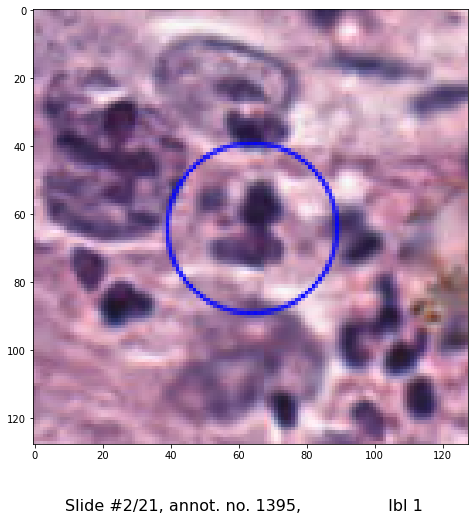

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



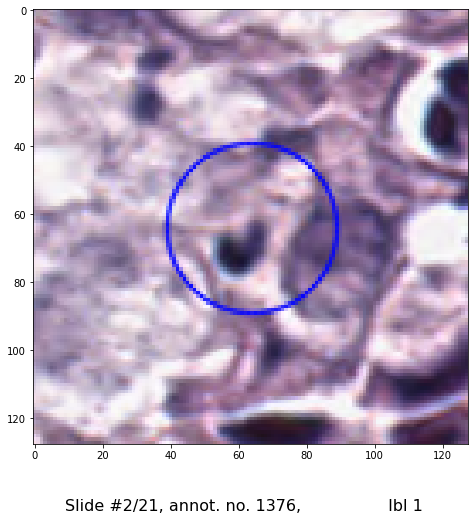

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



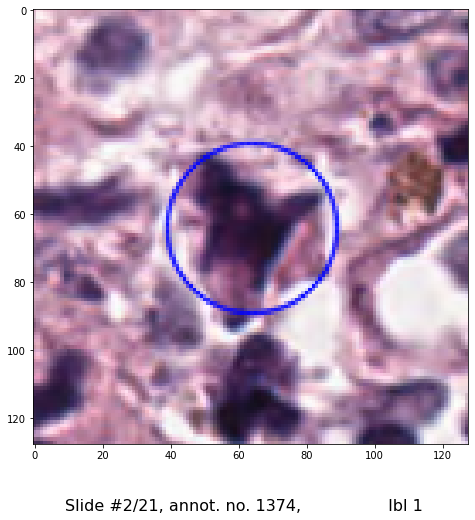

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



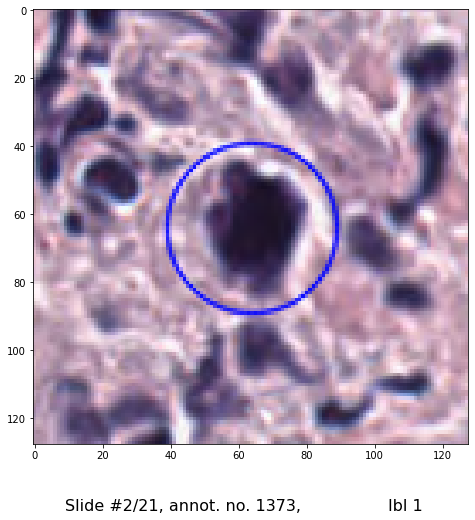

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



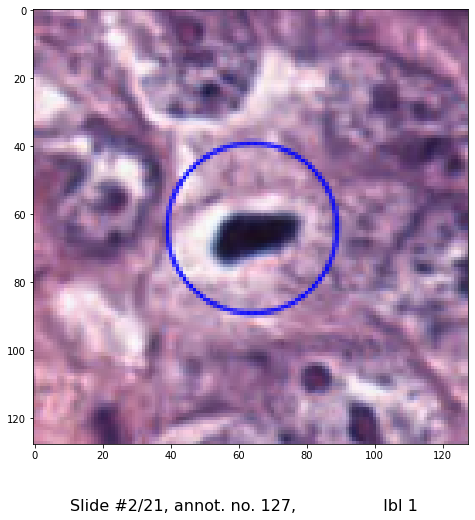

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



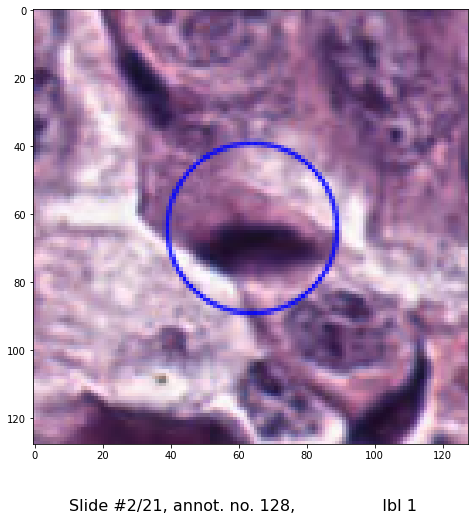

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



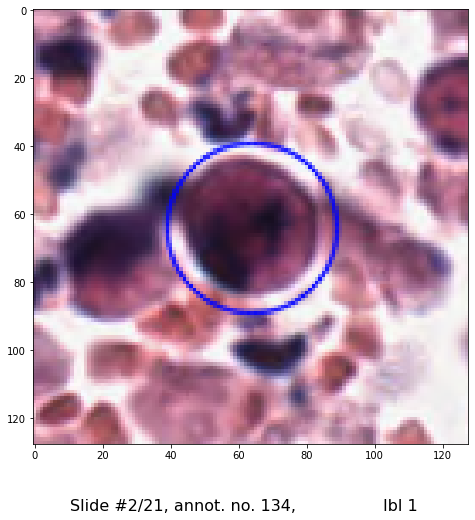

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



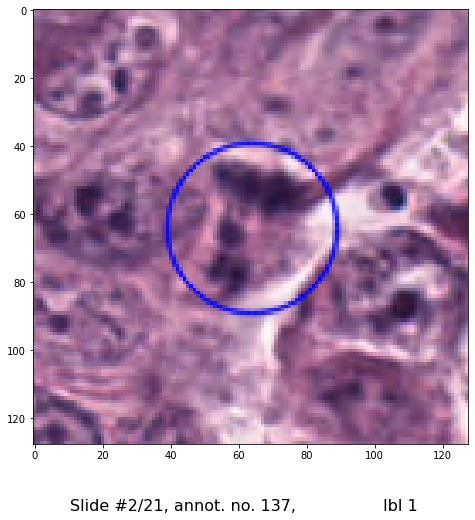

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....



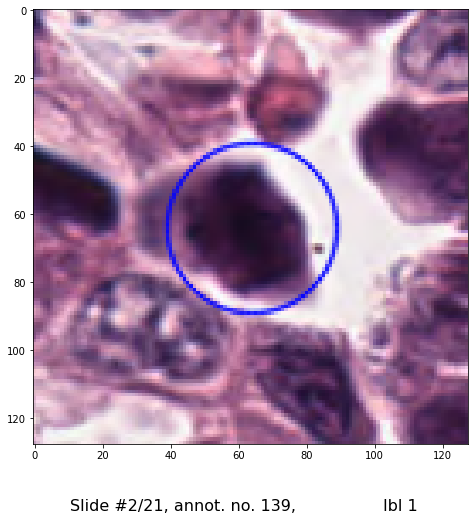

MLF subclassing label?  8


OK, confirming user subclass label =    8 written to annotation dataframe....

OK...32 MLF image patches subclassified with label = 8. 
Total of 34 patches VIEWED and SUBCLASSED as 8 or 0. 
You are done!





In [ ]:
# let's subclass some MLF's:
from SlideRunner.dataAccess.annotations import ViewingProfile
import matplotlib.pyplot as plt
import numpy as np

# prepare for looping through patches & requesting subclass label; set target 
# no. of subclass '8' patches desired (n)
# (= MLFs; = agreedClass sqlite db label of '1'):
n = 32

# set patch pixel dim:
pix_dim = 128

# set arguments for requesting user subclass label input using read_val fxn:
request_msg = 'MLF subclassing label? '
error_msg = 'Not a valid MLF subclassing label; please retry....\n'
val_range = [8,0]    # subclass labels must be 8 or 0 for this notebooks task

# add a 'subcl' column to df to hold subclass labels (if it doesn't exist), and
# fill with int(42), which is NOT in val_range:
annot_df_sorted['subcl'] = annot_df_sorted.get('subcl', int(42))

# loop through MLFs in annot_df_sorted, asking for user subclass label until n
# clear-cut examples of subclass '8' (MLF = sqlite agreedClass '1') are obtained;
# initialize mlf_8 annot. counter (counts no. patches VIEWED and SUBCLASSED as '8')
# and mlf_t counter = total no. patches VIEWED and subclassed as '8' OR '0'):
mlf_8 = 0
mlf_t = 0

while mlf_8 < n:

    # verify that total annot. counter hasn't exceeded no. MLFs in annot_df_sorted:
    if mlf_t >= len(annot_cl1_l):
        print(f'You_ve subclassed {mlf_t} patches as 8 or 0. If you proceed, \n'
              f'you_ll be entering agreedClass 2 = MF territory!!!\n\n')
        break

    # verify annot. is MEL sqlite db agreedClass 1 (MLF):
    assert int(annot_df_sorted.iat[mlf_t, 4]) == 1

    # verify annot. key = annot. uid
    assert int(annot_df_sorted.iat[mlf_t, 0]) == int(annot_df_sorted.iat[mlf_t, 1])
                                                   
    # use annot. uid
    annot_no = int(annot_df_sorted.iat[mlf_t, 1])   
    
    # get coord. of LU corner bb of dim pix_dim centered about annot.:                                
    LUx = int(int(annot_df_sorted.iat[mlf_t, 2][0]) - pix_dim/2)
    LUy = int(int(annot_df_sorted.iat[mlf_t, 2][1]) - pix_dim/2)
    lu  = (LUx, LUy)

    # get image patch & display:
    img = np.array(slide.read_region(lu, 0, [pix_dim, pix_dim]))[:,:,0:4]
    DB.annotations[annot_no].draw(image=img, leftUpper=lu, zoomLevel=1., 
                                  thickness=1, vp=ViewingProfile())
    
    caption = f'Slide #{slide_no}/21, annot. no. {annot_no}, \
                lbl {DB.annotations[annot_no].agreedClass}'
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.figtext(0.5, 0.01, caption, wrap=False, horizontalalignment='center', 
                fontsize=16)
    plt.show()

    # ask user for subclass label:
    subclass_label = read_val(int, val_range, request_msg, error_msg)

    # write user subclass label for patch to df:
    annot_df_sorted.iat[mlf_t, 6] = subclass_label
    print(f'\n\nOK, confirming user subclass label = {subclass_label:4d} '
          f'written to annotation dataframe....\n')

    # increment mlf_8 annot. counter ONLY if patch subclassed as '8' (otherwise it
    # wasn't a clear example of MLF):
    if subclass_label == int(8):
        mlf_8 += 1

    # increment total annot. counter = no. patches VIEWED & SUBCLASSED as '8' OR '0':
    mlf_t += 1

print(f'OK...{mlf_8} MLF image patches subclassified with label = 8. \n'
      f'Total of {mlf_t} patches VIEWED and SUBCLASSED as 8 or 0. \n'
      f'You are done!\n\n\n')

In [ ]:
# look at annot_df_sorted after completing subclassing all MLFs on this slide:
annot_df_sorted

<IPython.core.display.Javascript object>

,key,uid,ctr,coord,lbl,guid,subcl
0,1,1,"[21029, 7246]","[[21004, 7221], [21054, 7271]]",1,05535b17-a3f3-48f9-ae21-dbf9617efcf1,8
172,1378,1378,"[12420, 28597]","[[12395, 28572], [12445, 28622]]",1,39f4c617-c398-421b-a392-ba96a3e5c493,0
174,1380,1380,"[28407, 29819]","[[28382, 29794], [28432, 29844]]",1,64827d9b-9de4-4672-a413-a0c58fee8bff,8
175,1381,1381,"[28124, 29658]","[[28099, 29633], [28149, 29683]]",1,ebd10fc9-384f-450b-ab58-aed2869658c2,0
176,1382,1382,"[27694, 29623]","[[27669, 29598], [27719, 29648]]",1,3b021804-0fe4-4b34-81ea-ee8be751cc8d,8
178,1386,1386,"[31107, 31305]","[[31082, 31280], [31132, 31330]]",1,3f2beb85-8648-4821-a308-1be404f0ed29,8
180,1388,1388,"[7874, 32202]","[[7849, 32177], [7899, 32227]]",1,e7002dc1-c468-424f-a5c0-f14907519e1c,8
181,1389,1389,"[7803, 32209]","[[7778, 32184], [7828, 32234]]",1,7e3188fe-4d34-41e5-885b-ee67f1829c2e,8
182,1390,1390,"[14168, 33048]","[[14143, 33023], [14193, 33073]]",1,78b554d8-9df1-4ec5-aa64-5a5ab4e022c2,8
183,1391,1391,"[28267, 32810]","[[28242, 32785], [28292, 32835]]",1,56ef32ec-efe9-4180-a73a-ce121240eb51,8


In [ ]:
# write above df w/ MLFs subclassed to csv
# add time stamp:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

annot_df_sorted.to_csv('drive/MyDrive/sam/subclassing (see dropbox for dbs and xlsxs)/' +
                timestr + '_annot_df_sorted_subclassed_MLFs_32_slide_no_' + str(slide_no) + '.csv')

<IPython.core.display.Javascript object>